# Unveiling Cuban Landscapes: An Optimized Supervised Learning Model for Effective Land Cover Monitoring

<p style="text-align: center;">Student Number: 23215050</p>
<p style="text-align: center;">Word Count: ?</p>
<p style="text-align: center;">Created for CASA0006: Data Science for Spatial Systems</p>
<p style="text-align: center;">MSc. Urban Spatial Science — University College London (UCL)</p>
<p style="text-align: center;">April 2024</p>

<div align="center">

|
[1.0 Introduction](#introduction) | 
[Literature Review](#literature-review) | 
[Research Question](#research-question) | 
[Presentation of Data](#presentation-of-data) | 
[Methodology](#methodology) | 
[Results](#results) | 
[Discussion](#discussion) | 
[Conclusion](#conclusion) |

</div>

## 1.0 | Introduction

### 1.1 Requirements and Installation

The following libraries are required to run this notebook. The environment.yml file is provided to create a conda/mamba environment with the required libraries. Within it are the required packages and their versions.

To install the environment, run the following command in the terminal:
```bash
conda env create --name cuba_classification --file=environment.yml
```

Then to activate the environment you can run:
```bash
conda activate cuba_classification
```

You can now use the `cuba_classification` environment to run the code in this notebook.

In [1]:
# Raster Analysis
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge

# Vector Analysis
from shapely.geometry import box, mapping, Polygon

# General data manipulation
import geopandas as gpd
import pandas as pd
import numpy as np

# Saving and Accessing Data
import os
import pickle
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import folium

# Google Earth Engine
import ee
import geemap

# Machine learning

# Keras
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, Dense, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

# Sci-Kit Learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

# CART
from sklearn.tree import DecisionTreeClassifier

# random forest
from sklearn.ensemble import RandomForestClassifier

# xgboost
from xgboost import XGBClassifier

c:\Users\juane\miniforge3\envs\cuba_class_2\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


### 1.2 Google Earth Engine Authentication

To run the code, you will need to a Google Earth Engine account. When the notebook code below is first ran on your computer, it will open a browser window asking you to authenticate your account. Once you have done this, it will give you an access token which you can copy and paste into this notebook (where it requests it). You only need to do this once.

In [2]:
ee.Authenticate()
ee.Initialize()

### 1.3 Recomputing the Models

Due to long runtimes during model training and preprocessing, the various models and some of the preprocessed data is saved in the `models` and `temporary` folders. If you want to re-run *all* the code, you can delete these folders and re-run the notebook. **Note: This will take multiple hours**. If you want to re-run only parts of the code, you can delete the specific files you want to re-calculate.

## 2.0 Literature review

Cuba's land cover, as recorded by (Galford et al., 2018), is primarily agricultural, with a significant portion of mangrove cover. However, this landscape is likely to change due to the country's increasing foreign investment and tourism. Drastic changes to Cuba’s land have occurred before, such as through the transition from large-scale to small-scale farming following the end of Soviet subsidies (Machado, 2018). More specifically, there has been a long-term process of land reform in Cuba, which has seen a shift from peasant collectivization to re-peasantization (Botella-Rodríguez and González-Esteban, 2021). This transition has led to significant changes in agricultural land use. An increase in foreign and national investments in tourism may also lead to a greater expansion of urban areas, such as through the creation of tourist enclaves (González et al., 2014). These studies collectively suggest that Cuba's land cover has been changing, particularly in its agricultural and urban areas, due to both historical and recent factors. However, as we will further discuss, existing models for monitoring land cover changes in Cuba may fail to adequately detect these changes.

Complex models for determining the land cover of countries have been created before, such as in the UK (Marston et al., 2023), as they can help understand the natural and built environments of the nation (and any changes that may be occurring). Land cover models have also been created for the island of Cuba, as they are particularly beneficial for environmental conservation efforts (Gebelein, 2012; Galford et al., 2018; Nuñez-Penichet, Maita-Chamba and Soberón, 2023). However, existing land cover maps for Cuba were created as secondary points of information for a different research focus. They did not attempt (or at least not document) any process for optimizing the output of the classification models. Furthermore, these models are not readily available. 


Remote sensing datasets, such as those created by the Wildlife Conservation Society (WCS) and the Food and Agriculture Organization (FAO), have been used for understanding the changing landscapes of the island of Cuba (Machado, 2018). The FAO dataset in particular uses data provided from the NASA MODIS Land Cover Collection, as well as the European Space Agency’s (ESA) WorldCover project, both of which provide land cover estimates that cover the whole of Cuba. However, each of these existing estimates have notable flaws.

- The Human Footprint dataset provided by the WCS was designed to measure the intensity of human impact on the environment, and does not capture the variances in land cover. Furthermore, the data is only produced at 300m resolution (Sanderson et al., 2002, 2022).
- The MODIS land cover dataset created by NASA only has a resolution of 500m. Compared to other free satellite imagery available, such as from the Landsat and Sentinel missions (which have scanners able to produce images at 15 and 10 meter resolutions respectively), 500m can be considered very low resolution.
- The WorldCover project from the ESA  does provide land cover estimates for Cuba at 10 m accuracy for 2020 and 2021 (Zanaga et al., 2021, 2022). However, as with all global projects, it is difficult to accurately differentiate between a limited set of land cover types across the vast and varying landscape of Earth. Because of this, the improved WorldCover 2021 v200 model was only able to achieve an accuracy of 76.7% (Zanaga et al., 2022). 

In general, all existing models were designed for global analysis. They are greatly important for understanding worldwide phenomena, but may fail at capturing more minute details at high accuracy. This is why regional land cover initiatives are still so important, and why a Cuba focused model was needed to be made.

By creating an accurate model for predicting land cover in Cuba (that can be run on different years), we can better understand what changes are happening and where on the island.

## 3.0 Research Question

How can we develop an optimized and accurate land cover classification model tailored to the unique landscape of Cuba to effectively monitor and understand the dynamic changes occurring in agricultural and urban areas of the island? From this model, are we able to detect any significant changes in Cuba’s land cover over the past 10 years?


## 4.0 Presentation of Data

#### 4.1 Data Collection

We begin by preparing some constant variables that will be used throughout the notebook. Note that a seed is set for reproducibility.

In [33]:
SEED = 2024
keras.utils.set_random_seed(SEED)
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9']
LABEL = ['type']

CLASSES = [0, 1, 2, 3, 4, 5]
N_CLASSES = len(CLASSES)

CLASS_VALUES = {
    'urban': 0, 
    'deep_ocean': 1, 
    'shallow_waters': 2, 
    'agriculture': 3,
    'barren': 4,
    'forest': 5
}

class_labels = {v: k for k, v in CLASS_VALUES.items()}

# PALETTE = ['#f0027f', '#386cb0', '#ADD8E6', '#fdc086', '#ffff99', '#008080']
PALETTE = ['#e31a1c', '#1f78b4', '#a6cee3', '#fb9a99', '#b2df8a', '#33a02c']

NUM_SAMPLES_PER_CLASS = 10_000

We are using data collected from by the Landsat 8 satellite. This data is collected by the United States Geological Survey (USGS) and is available through Google Earth Engine (GEE). We will be using the `ee` library to access this data. 

In [4]:
# Define the image collection for the Landsat 8 data
image_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")


Cuba's territorial seas boundaries were collected from the MarineRegions database, managed by the Flanders Marine Institute. This was used to create a cutout of the island of Cuba from the global satellite dataset.

In [5]:
# Load the Cuba territorial seas shapefile (inside the data folder) using geopandas
cuba_territorial_seas = gpd.read_file(os.path.join('data', 'eez_12nm.zip'))


# The shapefile has only the shape of the territorial seas of Cuba, so we need to fill in the ring to capture
# the whole island.
def close_holes(poly: Polygon) -> Polygon:
        """
        Close polygon holes by limitation to the exterior ring.
        Args:
            poly: Input shapely Polygon
        Example:
            df.geometry.apply(lambda p: close_holes(p))
        """
        if poly.interiors:
            return Polygon(list(poly.exterior.coords))
        else:
            return poly

cuba_territorial_seas = cuba_territorial_seas.geometry.apply(lambda p: close_holes(p))

# Convert GeoPandas object to Earth Engine geometry
cuba_json = cuba_territorial_seas.to_json()
geometry_cuba = ee.FeatureCollection(json.loads(cuba_json))

Cannot find header.dxf (GDAL_DATA is not defined)


Satellite imagery often has clouds and other atmospheric disturbances that can affect the quality of the image. To remove these, the function `mask_clouds()` was created. This function uses a quality assessment band ('QA_PIXEL') where specific bits indicate the presence of clouds or their shadows. The function creates masks for these bits and applies them to the image, effectively filtering out the clouds and their shadows. The resulting image, with clouds removed, is then returned.

In [6]:
# Define a function to mask clouds for Landsat 8 images
def mask_clouds(image):
    L8cloudShadowBitMask = 1 << 3
    L8cloudsBitMask = 1 << 4
    L8Qa = image.select('QA_PIXEL')
    L8mask = L8Qa.bitwiseAnd(L8cloudShadowBitMask).eq(0) \
             .And(L8Qa.bitwiseAnd(L8cloudsBitMask).eq(0))
    return image.updateMask(L8mask)

We take our satellite image collection, clip out the island of Cuba using the previously loaded territorial seas boundary, mask out the clouds, and then filter the images to only include those from 2023. We then take the median of these images to create a composite image of Cuba for 2023. By taking the median, we reduce the effect of outliers in the data, such as those caused by atmostpheric disturbances or seasonal changes.

In [7]:
# Filter the Landsat images
landsat_cuba = image_collection.filterBounds(geometry_cuba).map(mask_clouds)

# Define start and end dates
start_date = ee.Date('2023-01-01')
end_date = ee.Date('2023-12-31')

# Filter by date
landsat_cuba = landsat_cuba.filterDate(start_date, end_date)

# Get median image, only for the geometry of cuba, and for bands with 30m resolution
median_image = landsat_cuba.median().clip(geometry_cuba).select(FEATURES)

Using bands 2, 3, and 4 (which correspond to the blue, green, and red bands of the satellite imagery), we create a true color image of Cuba for 2023. This image is then displayed using folium to create an iteractive map.

In [8]:
# Display the map
mapid = median_image.getMapId({'min': 0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']})

# Create a Folium map object
map = folium.Map(location=[22, -80], zoom_start=7)

# Add the Landsat image layer
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='Landsat Image',
).add_to(map)

# Add layer control
folium.LayerControl().add_to(map)

# Display the map
map

### 4.2 Subset Selection

Due to size and computational limits of this assignment, running each of the models on the entire island of Cuba is not feasible. Instead, we will be using a subset of Cuba to visualize the final results. Training and testing will be done on the entire island, thus the application of the model to the subset should be representative of the entire island.

The subset chosen is Cuba's second largest island, Isla de la Juventud (English: Isle of Youth). This island is located to the south-west of the main island of Cuba and is smaller in size while containing portions of all the land covers of interest. This makes it ideal for visualizing the results of the model.

In [9]:
# Define the geometry for the Isla de la Juventud
geometry_idlj = ee.Geometry.Polygon(
    [[[-83.21494438818296,21.4],
      [-82.5032363193353,21.4],
      [-82.5032363193353,21.93872306614785],
      [-83.21494438818296,21.93872306614785]]])

# Get median image, only for the geometry of Isla de la Juventud
# We will use this image for visually displaying the model results
median_idlj = landsat_cuba.median().clip(geometry_idlj).select(FEATURES)

For running our models on the subset, we must convert the Google Earth Engine image to an array that can be used by the scikit-learn library. Unfortunately, there is no direct way to do this. Instead, we must download the image from Earth Engine as a raster file and then read it back in as an array. Even though we are only working with a subset of the country, Google's download limits still prevent images of this size from being downloaded. To get around this, the function `split_geometry()` was created. This function takes in a geometry and splits it into smaller geometries that can be downloaded separately. 

In [10]:
# Function to split geometry into smaller subregions
def split_geometry(geometry, num_parts):
    bounds = geometry.bounds().getInfo()
    # Extracting bounding coordinates
    xmin = bounds['coordinates'][0][0][0]
    ymin = bounds['coordinates'][0][0][1]
    xmax = bounds['coordinates'][0][2][0]
    ymax = bounds['coordinates'][0][2][1]
    width = (xmax - xmin) / num_parts
    height = (ymax - ymin) / num_parts

    subgeometries = []
    for i in range(num_parts):
        for j in range(num_parts):
            subgeometry = box(xmin + i * width, ymin + j * height,
                              xmin + (i + 1) * width, ymin + (j + 1) * height)
            subgeometries.append(subgeometry)

    return subgeometries

The following code is now able to take the image object of the Isla de la Juventud, split it into smaller subsections, download each subsection, load it back in as an array, and then concatenate the arrays back together to create the full image raster array. This final array is saved so that it can be loaded in later without needing to re-download the GEE images. 

In [11]:
# Create a directory for temporary files if it doesn't exist
temp_dir = "temporary"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

output_path = os.path.join(temp_dir, "ildj_median_2023_merged.tif")
if not os.path.exists(output_path):
    # Split geometry into smaller subregions (to bypass Earth Engine export limit)
    subgeometries = split_geometry(geometry_idlj, num_parts=3)

    # Export and download each subregion
    for i, subgeometry in enumerate(subgeometries):
        output_filename = os.path.join(temp_dir, f"ildj_median_2023_part_{i}.tif")
        # Convert Shapely geometry to GeoJSON
        geojson_geometry = json.dumps(mapping(subgeometry))
        task = geemap.ee_export_image(median_idlj, filename=output_filename, region=geojson_geometry, scale=30)
        print(f"Exporting {output_filename}...")

    # Read and merge downloaded images
    output_files = [os.path.join(temp_dir, f"ildj_median_2023_part_{i}.tif") for i in range(len(subgeometries))]
    datasets = [rasterio.open(file) for file in output_files]
    merged, transform = merge(datasets)

    # Close the datasets
    for dataset in datasets:
        dataset.close()

    # Update the metadata
    profile = datasets[0].profile
    profile.update({"height": merged.shape[1], "width": merged.shape[2], "transform": transform})

    # Output merged image
    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(merged)

    # Delete smaller TIFF files
    for file in output_files:
        os.remove(file)
else:
    print("Found existing ildj_median_2023_merged.tif file. Using that instead.")

Found existing ildj_median_2023_merged.tif file. Using that instead.


In [12]:
median_image_raster = rasterio.open(output_path)
height = median_image_raster.height
width = median_image_raster.width
shape = (height, width)

With the image array loaded in, we can now visualize the resulting image of the Isla de la Juventud. We once again use the bands 2, 3, and 4 to create a true color image of the island, but use the library EarthPy to stretch each bands histogram to improve the contrast of the image.

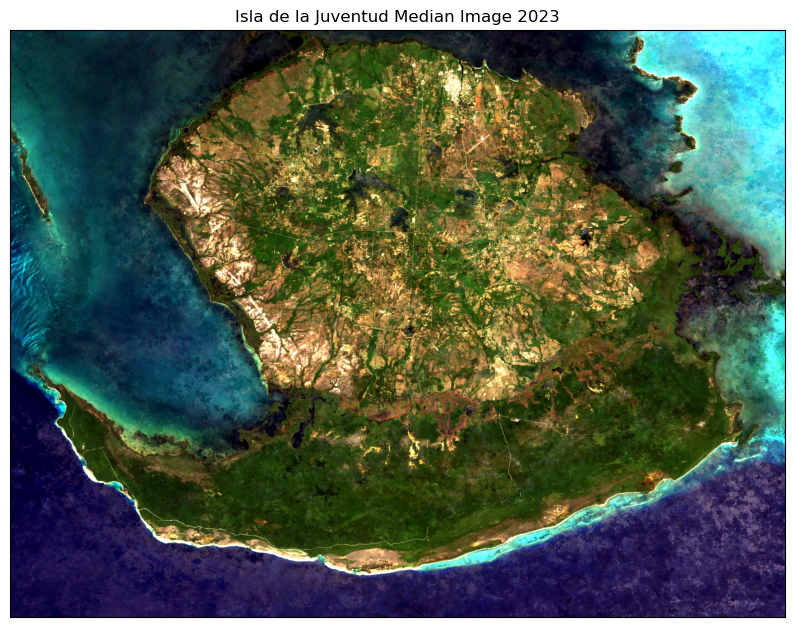

In [13]:
# Plot median_image_raster
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ep.plot_rgb(median_image_raster.read([4, 3, 2]), ax=ax, title="Isla de la Juventud Median Image 2023", stretch=True)
plt.show()

Although we used bands 2, 3, and 4 for visualization, we will be using bands 1-7 and 9 for the classification model. These bands correspond to the following wavelengths:

- Band 1: Coastal/Aerosol (0.43 - 0.45 µm)
- Band 2: Blue (0.45 - 0.51 µm)
- Band 3: Green (0.53 - 0.59 µm)
- Band 4: Red (0.64 - 0.67 µm)
- Band 5: Near Infrared (0.85 - 0.88 µm)
- Band 6: Shortwave Infrared 1 (1.57 - 1.65 µm)
- Band 7: Shortwave Infrared 2 (2.11 - 2.29 µm)
- Band 9: Cirrus (1.36 - 1.38 µm)

These bands were chosen since they all have 30 meter resolution and are commonly used for land cover classification.

We can plot the various bands separately to better understand the data we are working with. We can see that the bands have different characteristics, though it can be difficult to differentiate between the land cover types using only a visualize analysis of the bands. This is why we will be using a machine learning model to classify the land cover and extract data from the interactions between the bands that we are unable to see.

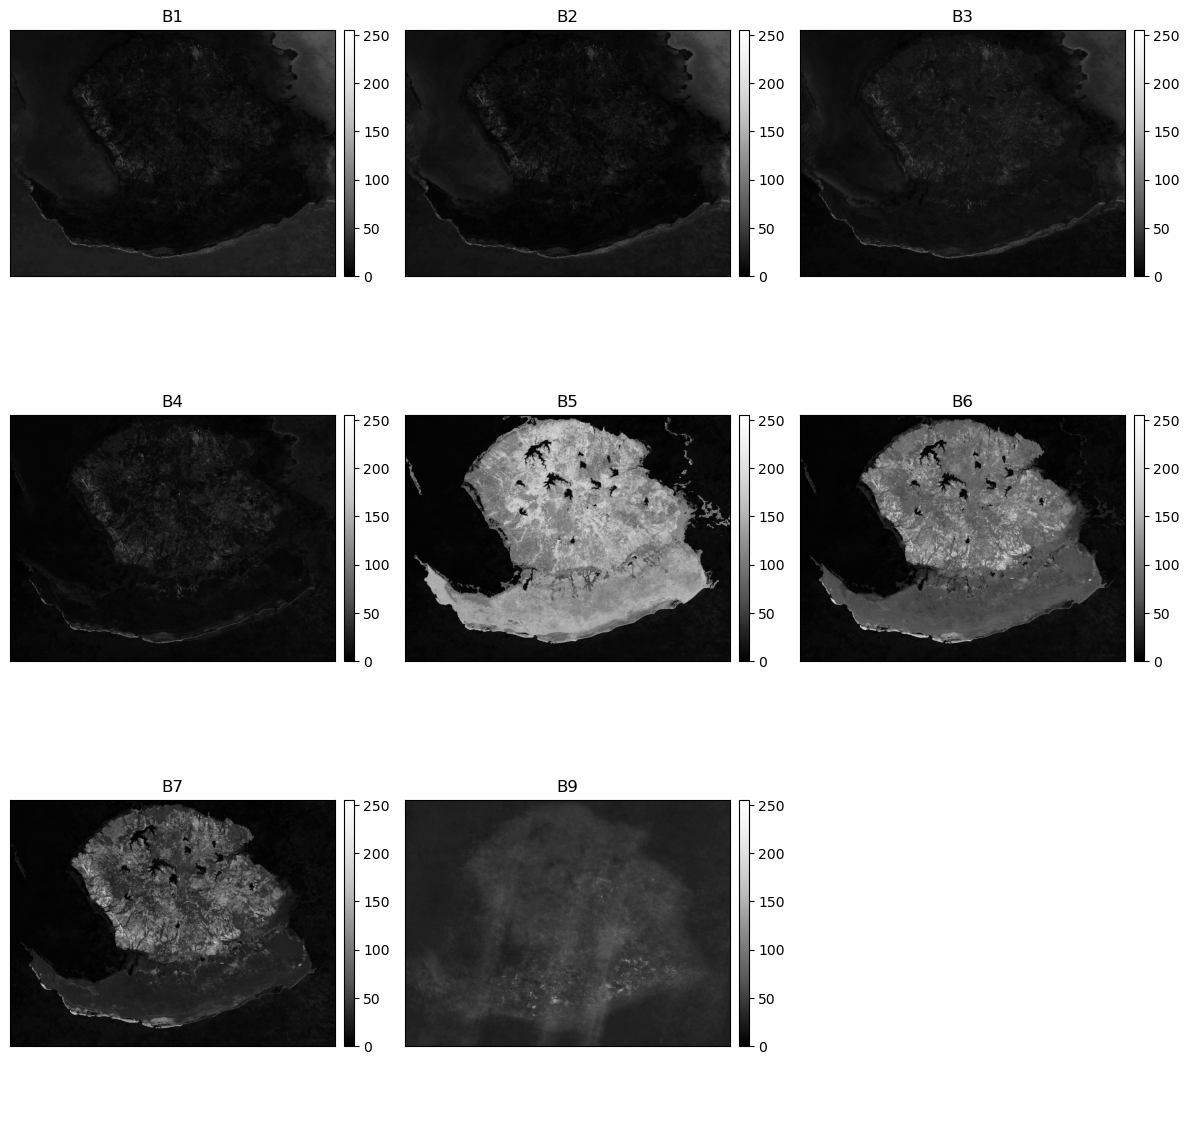

array([[<Axes: title={'center': 'B1'}>, <Axes: title={'center': 'B2'}>,
        <Axes: title={'center': 'B3'}>],
       [<Axes: title={'center': 'B4'}>, <Axes: title={'center': 'B5'}>,
        <Axes: title={'center': 'B6'}>],
       [<Axes: title={'center': 'B7'}>, <Axes: title={'center': 'B9'}>,
        <Axes: >]], dtype=object)

In [14]:
# plot median_image_raster using earthpy
ep.plot_bands(median_image_raster.read(), 
              title=["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B9"],
              cbar=True, scale=True)

### 4.3 Ground Truth Data (Sampling)

In [15]:
# Check if samples file exists
samples_path = os.path.join(temp_dir, "cuba_samples.csv")
if not os.path.exists(samples_path):
    print("Unable to find Cuba samples file. Creating a new one, this may take a while...")

    # Load cuba_samples_polygons.geojson as an Earth Engine FeatureCollection
    cuba_samples = geemap.geojson_to_ee(os.path.join('data', 'cuba_samples_polygons.geojson'))

    # Create an empty list to store the results
    result_list = []

    # Iterate through each 'type' in cuba_samples
    types = cuba_samples.aggregate_array("type").distinct().getInfo()

    for type_value in types:
        print("Sampling: ", type_value)
        # Filter cuba_samples by the current type
        samples_filtered = cuba_samples.filter(ee.Filter.eq("type", type_value))
        
        # Sample the median image at the locations of the filtered samples
        sampled_image = median_image.addBands(ee.Image.constant(CLASS_VALUES[type_value]).rename('int_type')).sample(
            region=samples_filtered.geometry(),
            scale=30,
            numPixels=NUM_SAMPLES_PER_CLASS,  # Specify the number of pixels to sample
            geometries=True,
            seed=SEED
        )
        
        # Add the sampled image to the result list
        result_list.append(sampled_image)

    # Merge all the results into a single ImageCollection
    extract = ee.FeatureCollection(result_list).flatten()

    # -----------------------------------------------------------

    print("Extracting data...")
    # Convert extract to a pandas DataFrame
    samples = geemap.ee_to_df(extract)
    
    # Add column 'int_type' that gives an integer value to each class
    samples['type'] = samples['int_type'].map(class_labels)

    samples = samples.sample(frac = 1, random_state=SEED) # Shuffle data

    # Save the samples to a CSV file in the temporary directory
    samples.to_csv(os.path.join(temp_dir, "cuba_samples.csv"), index=False)

    print("Cuba samples file created successfully.")

else:
    print("Found existing Cuba samples file. Using that instead.")
    samples = pd.read_csv(samples_path)

samples.head()

Found existing Cuba samples file. Using that instead.


,B1,B2,B3,B4,B5,B6,B7,B9,int_type,type
0,0.146778,0.129685,0.124542,0.109618,0.338564,0.267969,0.143241,0.000971,0,urban
1,0.104663,0.080174,0.064804,0.042566,0.236013,0.097950,0.038907,0.001069,5,forest
2,0.105999,0.082121,0.062945,0.040541,0.267835,0.117459,0.045047,0.001414,5,forest
3,0.120281,0.097365,0.083267,0.053222,0.378010,0.165814,0.062410,0.000693,4,barren
4,0.157431,0.137587,0.120909,0.115785,0.204957,0.264614,0.177775,0.000949,4,barren


In [34]:
import seaborn as sns

snspalette = {name: PALETTE[i] for i, name in enumerate(class_labels.values())}

# Use the color palette in the pairplot
sns.pairplot(samples.drop(columns=['int_type']).sample(frac=0.1, random_state=SEED), hue="type", palette=PALETTE)


## 5.0 Methodology

In [72]:
# Split data into training and testing (75% training, 25% testing)
train = samples.sample(frac=0.75, random_state=SEED)
test = samples.drop(train.index)

# Split between features and label
train_features = train[FEATURES]
train_label = train[['int_type']]
test_features = test[FEATURES]
test_label = test[['int_type']]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), num_classes=N_CLASSES + 1)
test_output = to_categorical(test_label.to_numpy(), num_classes=N_CLASSES + 1)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}')
print(f'Train label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (44208, 8, 1)
Test features: (14736, 8, 1)
Train label: (44208, 7)
Test label: (14736, 7)


## CART Model

We will use GridSearchCV to find the best parameters for our model.

In [18]:
# Modify train and test features to be 2D arrays (for CART and Random Forest)
train_x = train_input.reshape(train_input.shape[0], train_input.shape[1])
train_y = train_output.reshape(train_output.shape[0], train_output.shape[1])

test_x = test_input.reshape(test_input.shape[0], test_input.shape[1])
test_y = test_output.reshape(test_output.shape[0], test_output.shape[1])

In [19]:
# a CART using default settings
cart_default = DecisionTreeClassifier(random_state=SEED)
cart_default.fit(train_x, train_y)
# print the tree depth
print("Tree depth: {}".format(cart_default.get_depth()))

Tree depth: 34


In [20]:
# Create a directory for models files if it doesn't exist
models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [21]:
output_path = os.path.join(models_dir, "dt_final.pkl")
if not os.path.exists(output_path):
    
    print("CART model not found. Training a new one...")

    # values of max_depth and min_samples_split
    hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

    dt = DecisionTreeClassifier(random_state=SEED)

    # cv=5 by default, which means 5-fold cross-validation
    clf = GridSearchCV(dt, hyperparameters)

    clf.fit(train_x, train_y)

    # we can query the best parameter value and its accuracy score
    print("The best parameter value is: ")
    print(clf.best_params_)
    print("The best score is: ")
    print(clf.best_score_)

    print("Creating and training CART model with best parameters...")

    dt_final = DecisionTreeClassifier(max_depth=clf.best_params_['max_depth'], 
                                      min_samples_split=clf.best_params_['min_samples_split'], random_state=SEED)
    dt_final.fit(train_x, train_y)

    print("CART model trained successfully. Saving it in models folder...")

    # Save CART model
    with open(output_path, 'wb') as f:
        pickle.dump(dt_final, f)

    print("CART model saved successfully.")

else:
    print("Found existing CART model. Loading it in..")
    # load
    with open(output_path, 'rb') as f:
        dt_final = pickle.load(f)
    
    print("CART model loaded successfully.")

Found existing CART model. Loading it in..
CART model loaded successfully.


In [22]:
# Print the max depth and number of estimators for the dt_final model
print("Max depth: ", dt_final.get_params()['max_depth'])
print("Min samples split : ", dt_final.get_params()['min_samples_split'])

Max depth:  20
Min samples split :  2


In [23]:
print("Classification accuracy on the training data:")
print(dt_final.score(X=train_x, y=train_y))
print("Classification accuracy on the testing data:")
print(dt_final.score(X=test_x, y=test_y))

Classification accuracy on the training data:
0.9909971045964532
Classification accuracy on the testing data:
0.9140200868621065


In [24]:
# some attributes of the tree
print("Tree depth:{}".format(dt_final.get_depth()))
print("Number of leaves:{}".format(dt_final.get_n_leaves()))

Tree depth:20
Number of leaves:1934


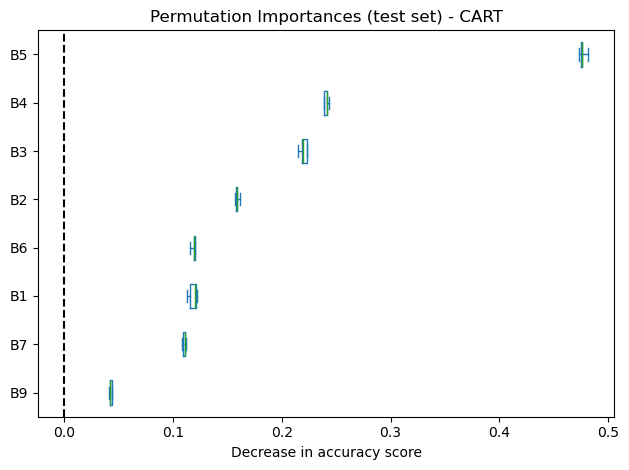

In [25]:
result = permutation_importance(
    dt_final, test_x, test_y, random_state=SEED
)

sorted_importances_idx = result.importances_mean.argsort()


importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=test_features.columns[sorted_importances_idx]
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set) - CART")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

## Random Forest Model

In [26]:
output_path = os.path.join(models_dir, "rf_final.pkl")
if not os.path.exists(output_path):
    
    print("Random Forest model not found. Training a new one...")

    # values of max_depth and min_samples_split
    hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

    rf = RandomForestClassifier(random_state=SEED)

    # cv=5 by default, which means 5-fold cross-validation
    clf = GridSearchCV(rf, hyperparameters)

    clf.fit(train_x, train_y)

    # we can query the best parameter value and its accuracy score
    print ("The best parameter value is: ")
    print (clf.best_params_)
    print ("The best score is: ")
    print (clf.best_score_)

    print("Creating and training Random Forest model with best parameters...")

    rf_final = RandomForestClassifier(max_depth=clf.best_params_['max_depth'], 
                                      min_samples_split=clf.best_params_['min_samples_split'], random_state=SEED)
    rf_final.fit(train_x, train_y)

    print("Random Forest model trained successfully. Saving it in models folder...")

    # Save RF model
    with open(output_path, 'wb') as f:
        pickle.dump(rf_final, f)

    print("Random Forest model saved successfully.")

else:
    print("Found existing Random Forest model. Loading it in..")
    # load
    with open(output_path, 'rb') as f:
        rf_final = pickle.load(f)
    
    print("Random Forest model loaded successfully.")

Found existing Random Forest model. Loading it in..
Random Forest model loaded successfully.


In [27]:
# Print the max depth and number of estimators for the rf_final model
print("Max depth: ", rf_final.get_params()['max_depth'])
print("Number of estimators: ", rf_final.get_params()['n_estimators'])

Max depth:  20
Number of estimators:  100


In [28]:
print("Classification accuracy on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("Classification accuracy on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

Classification accuracy on the training data:
0.9925805284111473
Classification accuracy on the testing data:
0.933699782844734


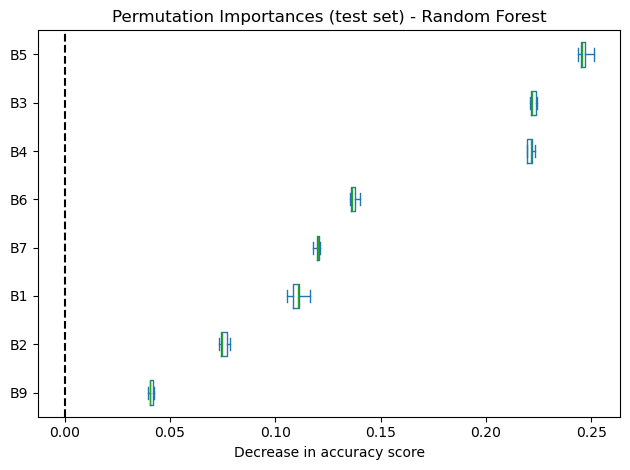

In [29]:
result = permutation_importance(
    rf_final, test_x, test_y, random_state=SEED
)

sorted_importances_idx = result.importances_mean.argsort()


importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=test_features.columns[sorted_importances_idx]
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set) - Random Forest")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

## XGBoost Model

In [30]:
output_path = os.path.join(models_dir, "xgb_final.pkl")
if not os.path.exists(output_path):
    
    print("XGBoost model not found. Training a new one...")

    # values of max_depth and min_samples_split
    hyperparameters = {'max_depth':[10,20,30,40,50], 'n_estimators':[50,100,150,200,250]}

    xgb = XGBClassifier(random_state=SEED)

    # cv=5 by default, which means 5-fold cross-validation
    gscv_xgb = GridSearchCV(xgb, hyperparameters)

    gscv_xgb.fit(train_x, train_y)

    # we can query the best parameter value and its accuracy score
    print ("The best parameter value is: ")
    print (gscv_xgb.best_params_)
    print ("The best score is: ")
    print (gscv_xgb.best_score_)

    print("Creating and training XGBoost model with best parameters...")

    xgb_final = XGBClassifier(max_depth=gscv_xgb.best_params_['max_depth'], 
                              n_estimators=gscv_xgb.best_params_['n_estimators'], random_state=SEED)
    xgb_final.fit(train_x, train_y)

    print("XGBoost model trained successfully. Saving it in models folder...")

    # Save XGB model
    with open(output_path, 'wb') as f:
        pickle.dump(xgb_final, f)

    print("XGBoost model saved successfully.")

else:
    print("Found existing XGBoost model. Loading it in..")
    # load
    with open(output_path, 'rb') as f:
        xgb_final = pickle.load(f)
    
    print("XGBoost model loaded successfully.")

Found existing XGBoost model. Loading it in..
XGBoost model loaded successfully.


In [31]:
# Print the max depth and number of estimators for the xgb_final model
print("Max depth: ", xgb_final.get_params()['max_depth'])
print("Number of estimators: ", xgb_final.get_params()['n_estimators'])

Max depth:  30
Number of estimators:  150


In [32]:
print("Classification accuracy on the training data:")
print(xgb_final.score(X=train_x, y=train_y))
print("Classification accuracy on the testing data:")
print(xgb_final.score(X=test_x, y=test_y))

Classification accuracy on the training data:
1.0
Classification accuracy on the testing data:
0.9368892508143323


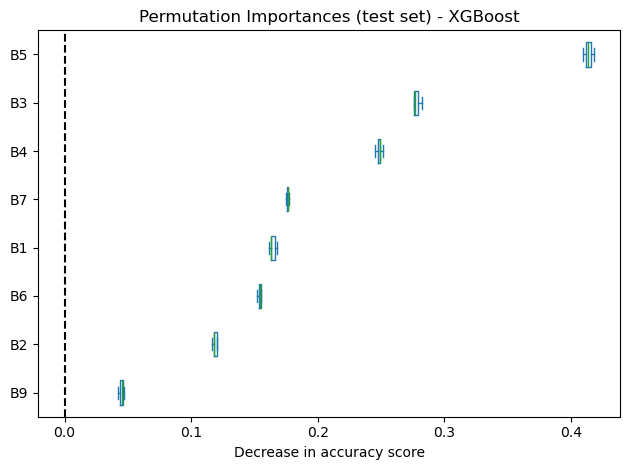

In [33]:
result = permutation_importance(
    xgb_final, test_x, test_y, random_state=SEED
)

sorted_importances_idx = result.importances_mean.argsort()


importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=test_features.columns[sorted_importances_idx]
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set) - XGBoost")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

## Neural Network Model

### Make Model

In [34]:
output_path = os.path.join(models_dir, "nn_final.keras")
if not os.path.exists(output_path):
    
    print("Neural Network model not found. Making a new one...")

    # Make model for our data
    # Input shape
    train_shape = train_input.shape
    input_shape = (train_shape[1], train_shape[2])

    # Model parameter
    neuron = 64
    drop = 0.2
    kernel = 5

    # Make sequential model
    nn_model = Sequential([
        Input(input_shape),
        Conv1D(neuron * 1, kernel, activation='relu', padding='same'),
        Conv1D(neuron * 1, kernel, activation='relu', padding='same'),
        Dropout(drop),
        Conv1D(neuron * 2, kernel, activation='relu', padding='same'),
        Conv1D(neuron * 2, kernel, activation='relu', padding='same'),
        Dropout(drop),
        GlobalMaxPooling1D(),
        Dense(neuron * 4, activation='relu'),
        Dropout(drop),
        Dense(neuron * 2, activation='relu'),
        Dropout(drop),
        Dense(N_CLASSES + 1, activation='softmax')
    ])

    need_to_train_nn = True
    nn_model.summary()


else:
    print("Found existing Neural Network model. Loading it in..")
    # load
    nn_model = keras.models.load_model(output_path)
    need_to_train_nn = False
    print("Neural Network model loaded successfully.")


Found existing Neural Network model. Loading it in..
Neural Network model loaded successfully.


### Train Model

In [35]:
if need_to_train_nn:
    print("Training Neural Network model...")
    
    # Compile the model
    nn_model.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',  # Updated the loss parameter
        metrics=['accuracy']
    )

    # Create callback to stop training if loss not decreasing
    stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
    )

    # Fit the model
    result = nn_model.fit(
        x=train_input, y=train_output,
        validation_data=(test_input, test_output),
        batch_size=1024,
        callbacks=[stop],
        epochs=1000,
    )
    history = pd.DataFrame(result.history)

    # Save the fit results
    with open(os.path.join(models_dir, "nn_fit_history.pkl"), 'wb') as f:
        pickle.dump(history, f)

    # Save the model
    nn_model.save(output_path)
else:
    print("Neural Network model already trained.")
    
    with open(os.path.join(models_dir, "nn_fit_history.pkl"), 'rb') as f:
        history = pickle.load(f)

Neural Network model already trained.


In [36]:
# Plot the model
# plot_model(nn_model, to_file=os.path.join(temp_dir, "nn_model_plot.png"), show_shapes=True, 
#            show_layer_names=False, rankdir='TB', show_trainable=True)


<img src="images/nn_model_plot.png" width="200">

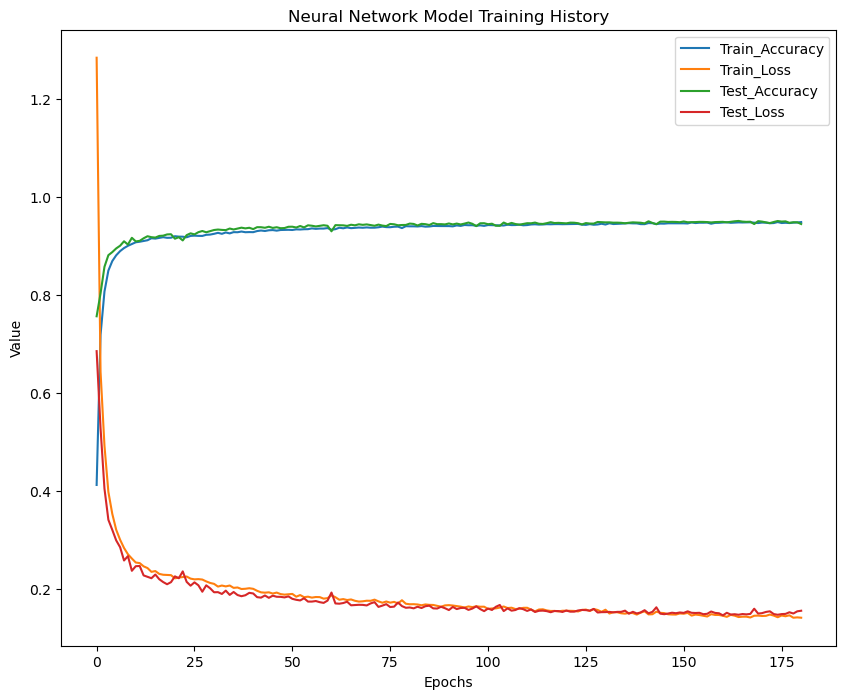

In [37]:
# Show history

plt.figure(figsize = (10, 8))

plt.plot(range(len(history['accuracy'].values.tolist())), 
         history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')

plt.plot(range(len(history['val_accuracy'].values.tolist())), 
         history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')

plt.xlabel('Epochs')
plt.ylabel('Value')

# Add title
plt.title('Neural Network Model Training History')


plt.legend()
plt.show()

In [38]:
# Print the R2 score
nn_model_train_score = nn_model.evaluate(train_input, train_output)
nn_model_test_score = nn_model.evaluate(test_input, test_output)

print("Classification accuracy on the training data:")
print(nn_model_train_score[1])
print("Classification accuracy on the testing data:")
print(nn_model_test_score[1])

1382/1382 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9533 - loss: 0.1298
461/461 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9499 - loss: 0.1421
Classification accuracy on the training data:
0.9533116221427917
Classification accuracy on the testing data:
0.9486970901489258


## Run Models on Isla de La Juventud

In [39]:
src_array = median_image_raster.read()
bands = median_image_raster.count

In [40]:
row_per_pixel = src_array.reshape([bands,-1]).T
columns = [f'band_{n}' for n in range(1,bands+1)]
row_per_pixel_df  = pd.DataFrame(row_per_pixel,columns=columns)

In [26]:
# Check if model predictions pickle file exists
output_path = os.path.join(temp_dir, "model_predictions.pkl")
if not os.path.exists(output_path):
    print("Model predictions file not found. Creating a new one...")

    # CART PREDICTION ---------------------------------------------------
    print("Predicting land cover using CART model...")

    dt_prediction = dt_final.predict(row_per_pixel_df).astype('float64')
    dt_prediction = np.argmax(dt_prediction, 1)
    dt_prediction = dt_prediction.reshape(shape[0], shape[1])

    # RANDOM FOREST PREDICTION --------------------------------------------
    print("Predicting land cover using Random Forest model...")

    rf_prediction = rf_final.predict(row_per_pixel_df).astype('float64')
    rf_prediction = np.argmax(rf_prediction, 1)
    rf_prediction = rf_prediction.reshape(shape[0], shape[1])

    # XGBOOST PREDICTION ---------------------------------------------------
    print("Predicting land cover using XGBoost model...")

    xgb_prediction = xgb_final.predict(row_per_pixel_df).astype('float64')
    xgb_prediction = np.argmax(xgb_prediction, 1)
    xgb_prediction = xgb_prediction.reshape(shape[0], shape[1])

    # NEURAL NETWORK PREDICTION ---------------------------------------------------
    print("Predicting land cover using Neural Network model...")

    # NN Prediction requires slightly different steps due to the model's input shape
    image_input = []
    for x in range(8):
        image_input.append(median_image_raster.read(x + 1))
    image_input = reshape_input(np.stack(image_input).reshape(8, -1).T)

    # Predict
    nn_prediction = nn_model.predict(image_input, batch_size=4096*20)
    nn_prediction = np.argmax(nn_prediction, 1)
    nn_prediction = nn_prediction.reshape(shape[0], shape[1])

    print("Saving results...")
    # Save model predictions
    with open(output_path, 'wb') as f:
        pickle.dump({
            'dt_prediction': dt_prediction,
            'rf_prediction': rf_prediction,
            'xgb_prediction': xgb_prediction,
            'nn_prediction': nn_prediction
        }, f)

    model_predictions = {"Decision Tree": dt_prediction, "Random Forest": rf_prediction, 
                         "XGBoost": xgb_prediction, "Neural Network": nn_prediction}

    print("Model predictions file created successfully.")

else:
    print("Found existing model predictions file. Loading it in..")
    # load
    with open(output_path, 'rb') as f:
        model_predictions = pickle.load(f)
    
    dt_prediction = model_predictions['dt_prediction']
    rf_prediction = model_predictions['rf_prediction']
    xgb_prediction = model_predictions['xgb_prediction']
    nn_prediction = model_predictions['nn_prediction']

    
    print("Model predictions loaded successfully.")

Found existing model predictions file. Loading it in..
Model predictions loaded successfully.


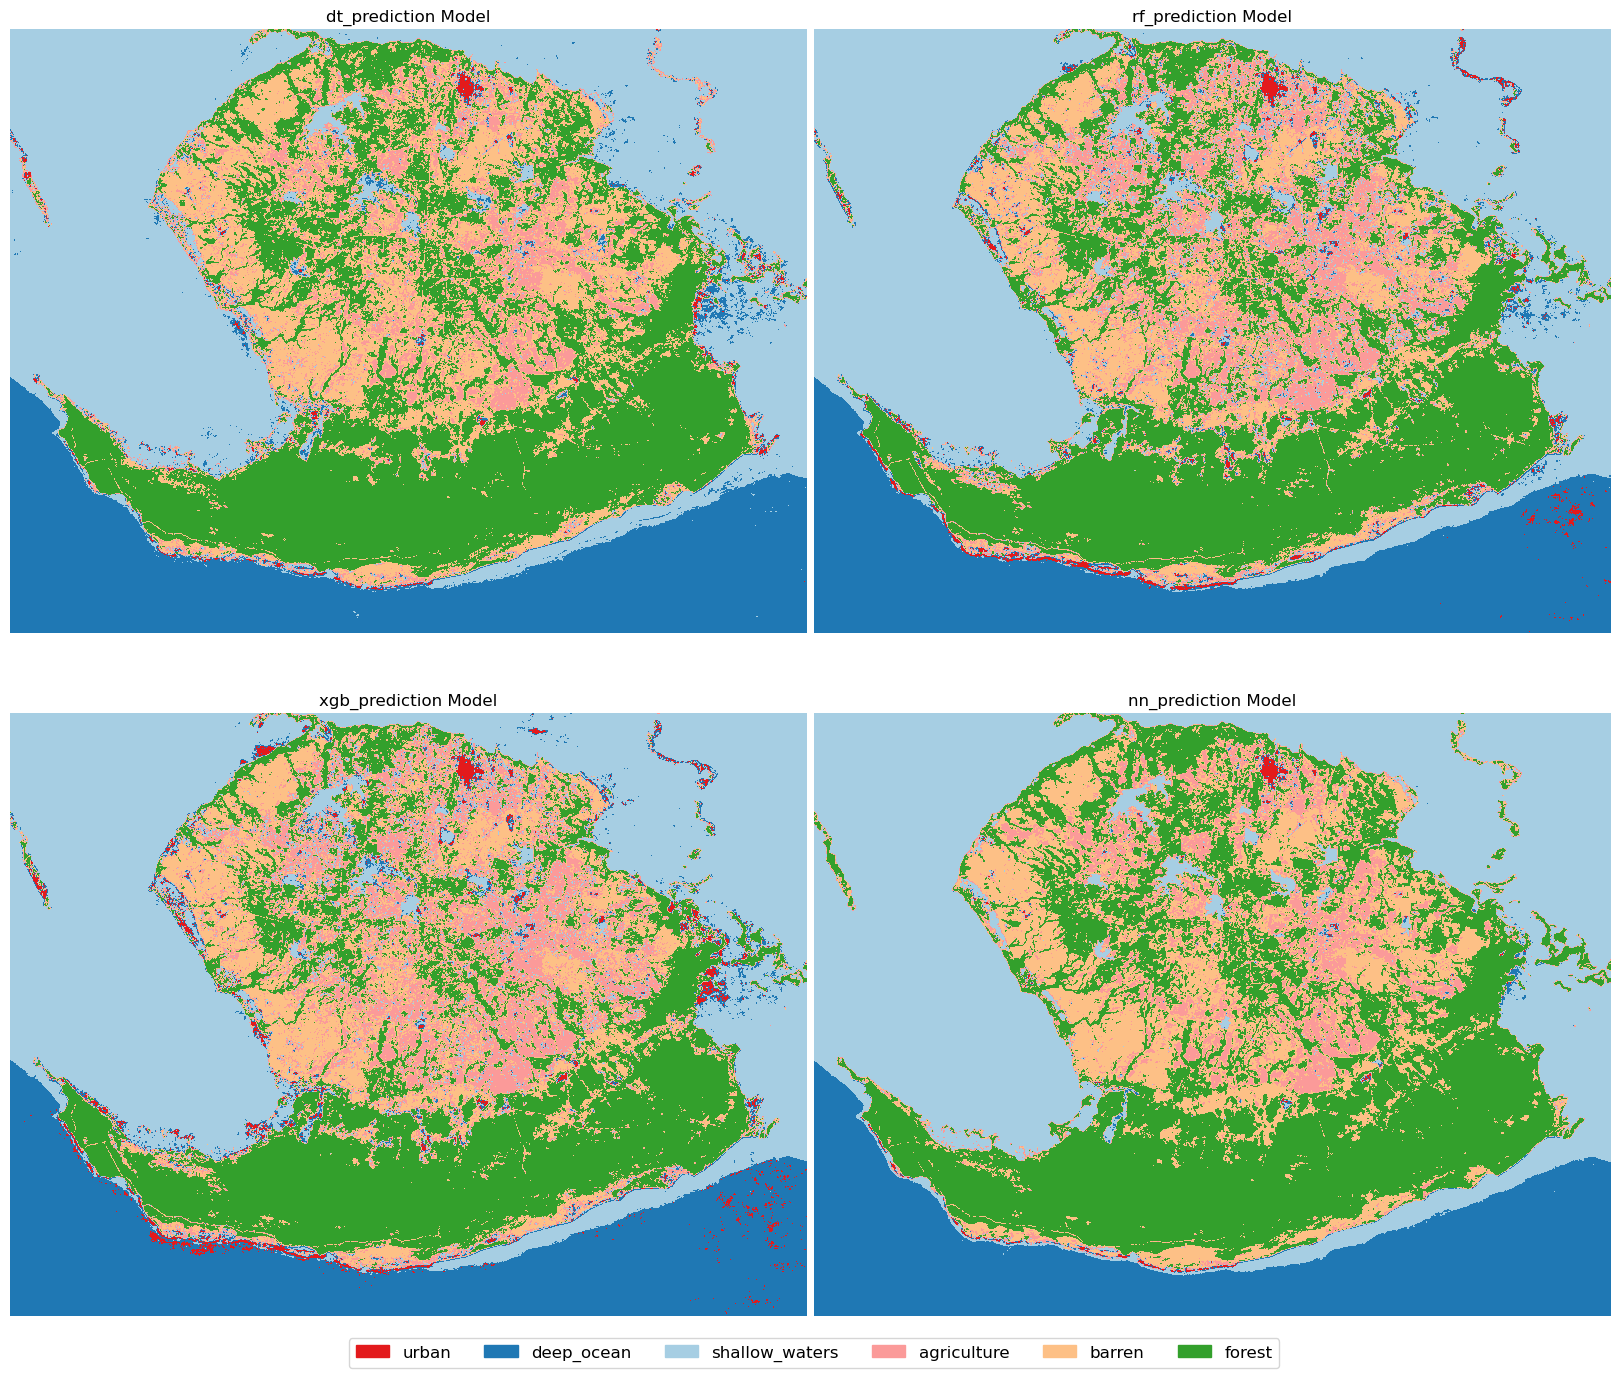

In [32]:
# Create a custom colormap with class labels
colors = [PALETTE[i] for i in CLASSES]
cmap = ListedColormap(colors)

# Plotting the results of each model in separate subplots
num_models = 4
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
for i, (key, value) in enumerate(model_predictions.items()):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Plot the results of the current model
    ax.imshow(value, cmap=cmap)
    
    # Add title for the subplot
    ax.set_title(f"{key} Model")
    
    # Remove axis
    ax.axis('off')

# Create a custom legend
legend_handles = [mpatches.Patch(color=PALETTE[i], label=class_labels[i]) for i in CLASSES]
plt.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0, -0.1), ncol=len(CLASSES), fontsize='12')

plt.subplots_adjust(hspace=0.01, wspace=0.01, bottom=0.15, top=1, left=0, right=1)

plt.show()

In [44]:
# create a list of models
list_name_models = ['CART', 'RF', 'XGBoost']
# use the models from above
list_reg_models = [dt_final, rf_final, xgb_final]

dict_models = dict()

for name, model in zip(list_name_models, list_reg_models):
    dict_models[name] = [model.score(train_x, train_y), model.score(test_x, test_y), 
                         model.score(train_x, train_y) - model.score(test_x, test_y)]

# add the neural network model
dict_models['Neural Network'] = [nn_model_train_score[1], nn_model_test_score[1], 
                                 nn_model_train_score[1] - nn_model_test_score[1]]

# transform dict_models to dataframe
df_models = pd.DataFrame.from_dict(dict_models, orient='index', columns=['Train Accuracy', 'Test Accuracy', 'Acc. Diff'])
df_models = df_models.sort_values(by='Acc. Diff', ascending=True)

df_models

,Train Accuracy,Test Accuracy,Acc. Diff
Neural Network,0.953312,0.948697,0.004615
RF,0.992581,0.933700,0.058881
XGBoost,1.000000,0.936889,0.063111
CART,0.990997,0.914020,0.076977


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


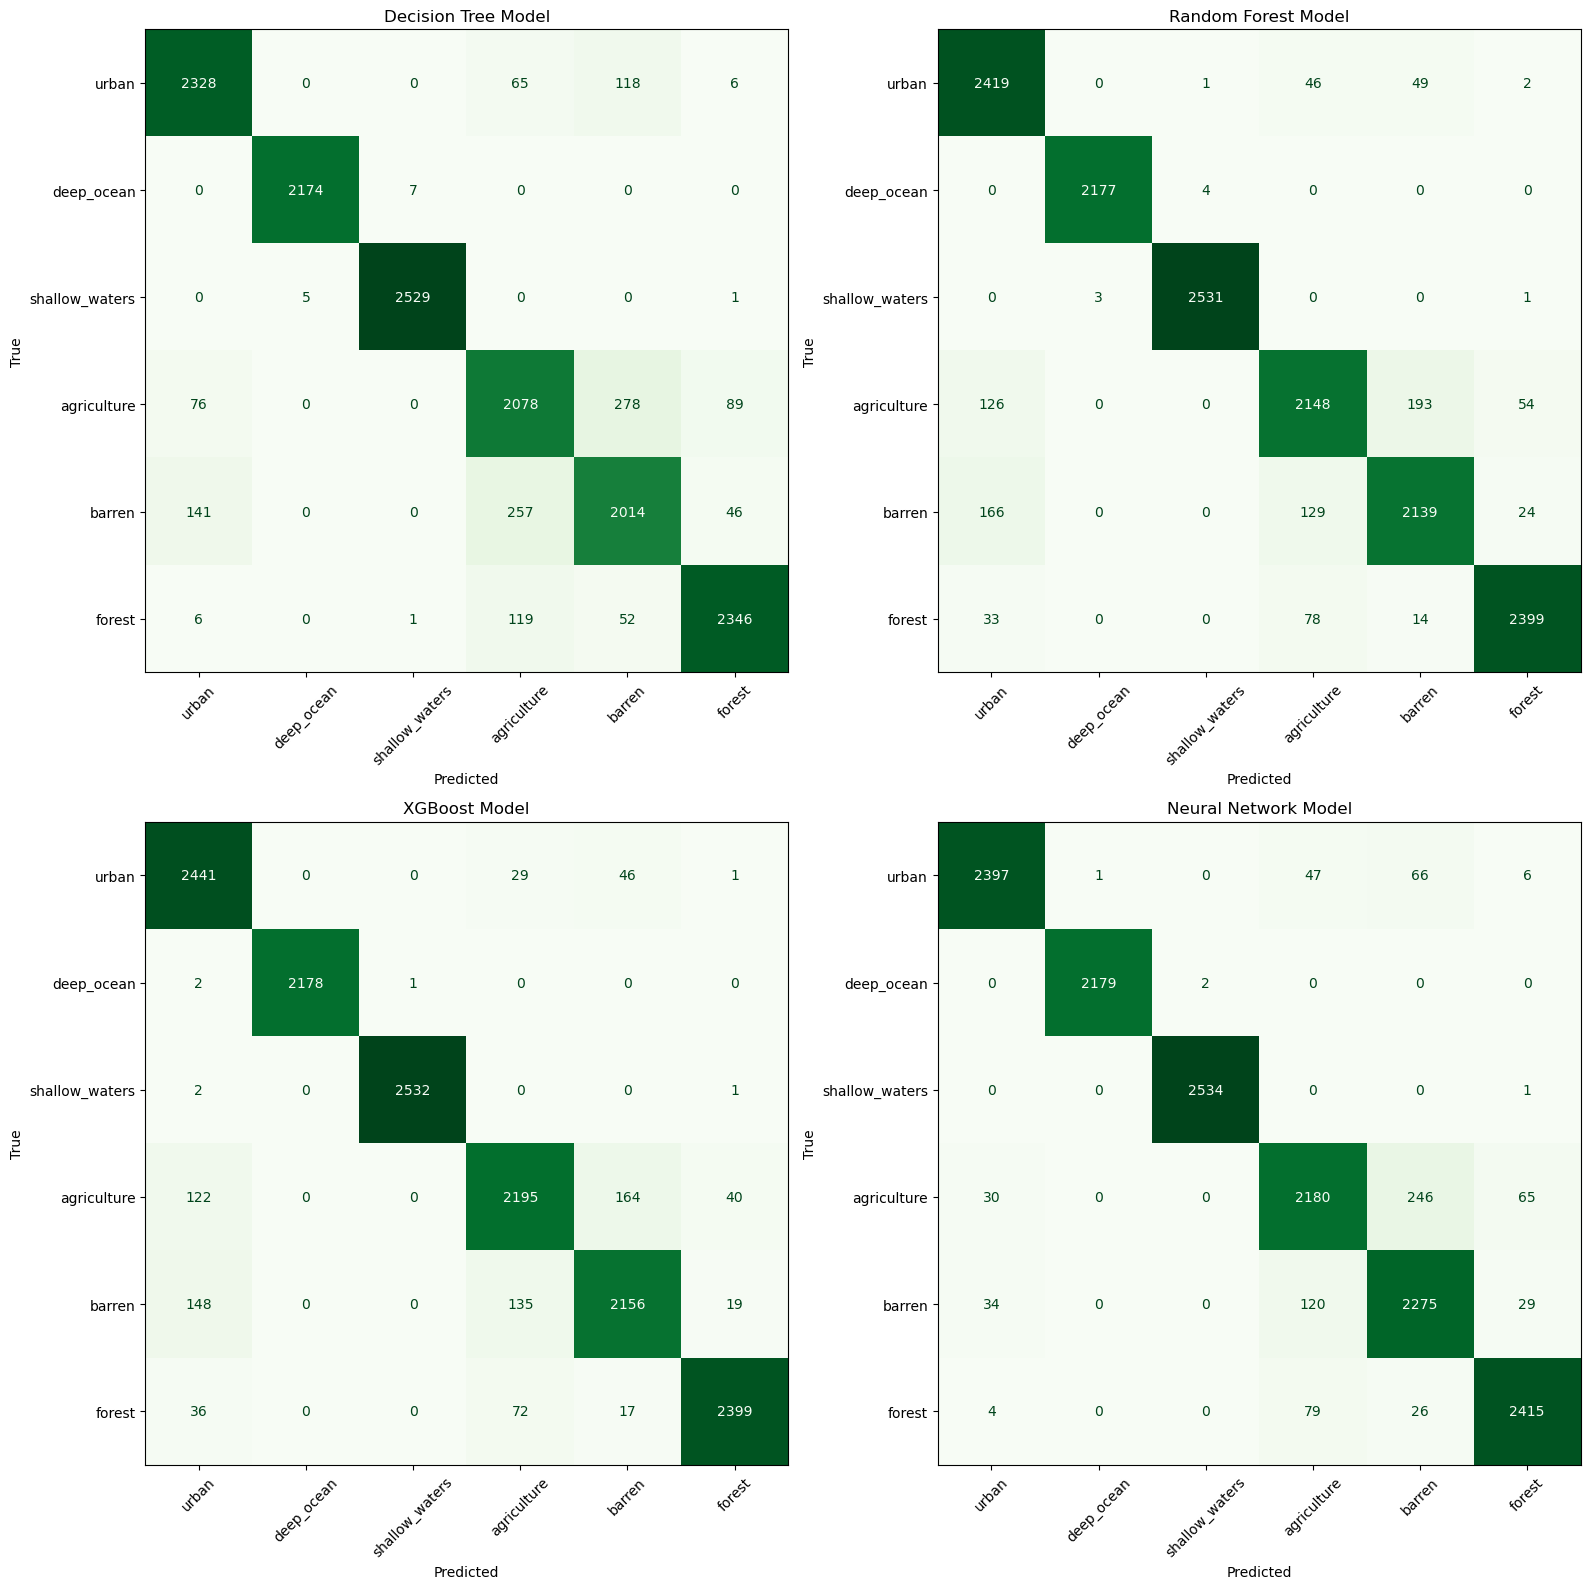

In [45]:
# Plot the confusion matrix for all models
models = {"Decision Tree": dt_final, "Random Forest": rf_final, "XGBoost": xgb_final, "Neural Network": nn_model}

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
for i, (key, value) in enumerate(models.items()):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Make predictions
    if key == "Neural Network":
        y_pred = value.predict(test_input, batch_size=4096*20)
        y_pred = np.argmax(y_pred, 1)
        y_true = np.argmax(test_output, 1)
    else:
        y_pred = value.predict(test_x)
        y_pred = np.argmax(y_pred, 1)
        y_true = np.argmax(test_y, 1)

    # Plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(N_CLASSES))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels.values())
    disp.plot(cmap='Greens', ax=ax)
    ax.set_title(f"{key} Model")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    # Hide colorbar
    disp.im_.colorbar.remove()

    # Tilt x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [46]:
# Functions for plotting classification report
# Source: https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, 
            correct_orientation=False, cmap='RdBu', vmin=None, vmax=None):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap, vmin=vmin, vmax=vmax)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    for y in range(AUC.shape[0]):
        for x in range(AUC.shape[1]):
            plt.text(x + 0.5, y + 0.5, '%.2f' % AUC[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
    

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu', 
                               vmin=None, vmax=None):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []

    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0}'.format(class_names[idx]) for idx, sup  in enumerate(support)]
    figure_width = 12
    figure_height = len(class_names) + 4
    correct_orientation = False
        
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, 
            correct_orientation, cmap=cmap, vmin=vmin, vmax=vmax)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step


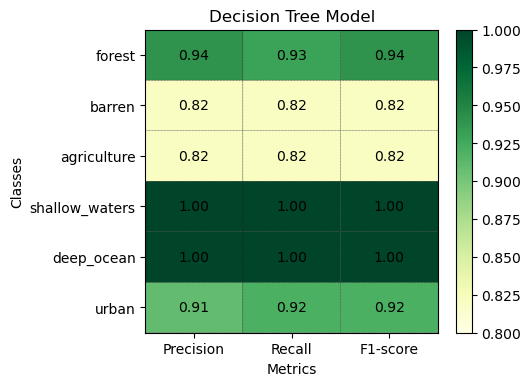

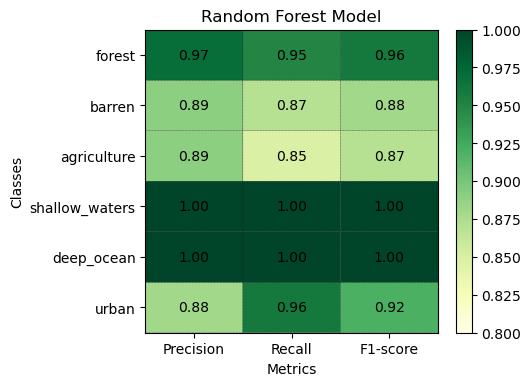

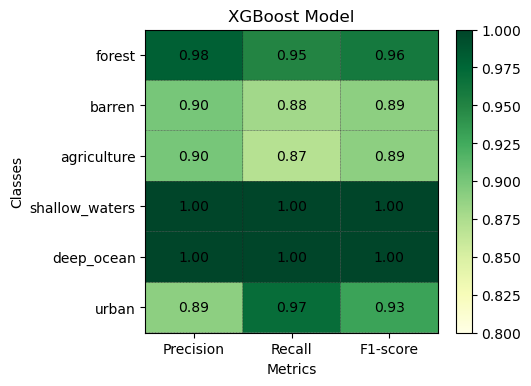

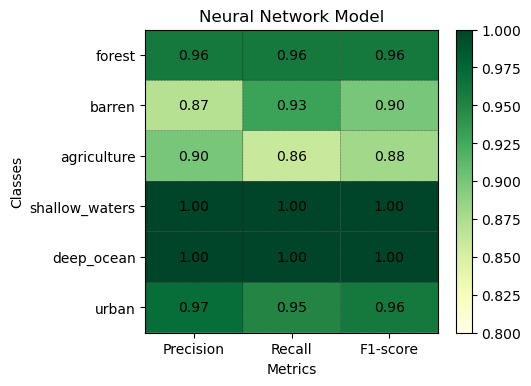

In [47]:
# Plot the classification report for all models
models = {"Decision Tree": dt_final, "Random Forest": rf_final, "XGBoost": xgb_final, "Neural Network": nn_model}

for i, (key, value) in enumerate(models.items()):
    
    # Make predictions
    if key == "Neural Network":
        y_pred = value.predict(test_input, batch_size=4096*20)
        y_pred = np.argmax(y_pred, 1)
        y_true = np.argmax(test_output, 1)
    else:
        y_pred = value.predict(test_x)
        y_pred = np.argmax(y_pred, 1)
        y_true = np.argmax(test_y, 1)

    # Plot the classification report
    class_report = classification_report(y_true, y_pred, target_names=class_labels.values())
    
    # Plot the classification report
    plot_classification_report(class_report, title=f"{key} Model", cmap='YlGn', vmin=0.8, vmax=1.0)


In [48]:
# What percentage of the pixels in the image are classified as each class within the neural network model?
unique, counts = np.unique(nn_prediction, return_counts=True)
prediction_counts = dict(zip(unique, counts))

# Calculate the percentage of each class
total_pixels = np.prod(shape)
percentage_counts = {class_labels[key]: value / total_pixels * 100 for key, value in prediction_counts.items()}
percentage_counts

{'urban': 0.8349901423330643,
 'deep_ocean': 16.07881142324746,
 'shallow_waters': 34.08603130404796,
 'agriculture': 9.070603885138329,
 'barren': 12.64951929221422,
 'forest': 27.280043953018975}

# Run Neural Network Model on Yearly Data

In [49]:
years_to_test = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
yearly_results = {year: {} for year in years_to_test}

yearly_results[2023] = percentage_counts

In [50]:
output_path = os.path.join(temp_dir, "yearly_results.pkl")
if not os.path.exists(output_path):
    for year in years_to_test:
        print(f"Processing year {year}...")
        print("Downloading median image...")

        # Filter the Landsat images
        landsat_cuba = image_collection.filterBounds(geometry_cuba).map(mask_clouds)

        # Define start and end dates
        start_date = ee.Date(f'{year}-01-01')
        end_date = ee.Date(f'{year}-12-31')

        # Filter by date
        landsat_cuba = landsat_cuba.filterDate(start_date, end_date)

        # Get median image, only for the geometry of Isla de la Juventud
        # We will use this image for visually displaying the model results
        median_idlj = landsat_cuba.median().clip(geometry_idlj).select(FEATURES)

        print("Converting median image to raster...")

        # Split geometry into smaller subregions (to bypass Earth Engine export limit)
        subgeometries = split_geometry(geometry_idlj, num_parts=3)

        output_path = os.path.join(temp_dir, f"ildj_median_{year}_merged.tif")

        # Export and download each subregion
        for i, subgeometry in enumerate(subgeometries):
            output_filename = os.path.join(temp_dir, f"ildj_median_{year}_part_{i}.tif")
            # Convert Shapely geometry to GeoJSON
            geojson_geometry = json.dumps(mapping(subgeometry))
            task = geemap.ee_export_image(median_idlj, filename=output_filename, region=geojson_geometry, scale=30)
            print(f"Exporting {output_filename}...")

        # Read and merge downloaded images
        output_files = [os.path.join(temp_dir, f"ildj_median_{year}_part_{i}.tif") for i in range(len(subgeometries))]
        datasets = [rasterio.open(file) for file in output_files]
        merged, transform = merge(datasets)

        # Close the datasets
        for dataset in datasets:
            dataset.close()

        # Update the metadata
        profile = datasets[0].profile
        profile.update({"height": merged.shape[1], "width": merged.shape[2], "transform": transform})

        # Output merged image
        with rasterio.open(output_path, "w", **profile) as dst:
            dst.write(merged)

        # Delete smaller TIFF files
        for file in output_files:
            os.remove(file)

        print("Predicting landcover using Neural Network model...")

        median_image_raster = rasterio.open(output_path)
        height = median_image_raster.height
        width = median_image_raster.width
        shape = (height, width)

        image_input = []
        for x in range(8):
            image_input.append(median_image_raster.read(x + 1))
        image_input = reshape_input(np.stack(image_input).reshape(8, -1).T)

        # Predict
        nn_prediction = nn_model.predict(image_input, batch_size=4096*20)
        nn_prediction = np.argmax(nn_prediction, 1)
        nn_prediction = nn_prediction.reshape(shape[0], shape[1])

        print("Saving results...")

        # What percentage of the pixels in the image are classified as each class within the neural network model?
        unique, counts = np.unique(nn_prediction, return_counts=True)
        prediction_counts = dict(zip(unique, counts))

        # Calculate the percentage of each class
        total_pixels = np.prod(shape)
        percentage_counts = {class_labels[key]: value / total_pixels * 100 for key, value in prediction_counts.items()}
        
        yearly_results[year] = percentage_counts

        # Close the raster
        median_image_raster.close()

        os.remove(output_path)

    # Save results to pickle file
    output_path = os.path.join(temp_dir, "yearly_results.pkl")
    with open(output_path, 'wb') as f:
        pickle.dump(yearly_results, f)
else:
    print("Found existing yearly results file. Loading it in..")
    with open(output_path, 'rb') as f:
        yearly_results = pickle.load(f)

Found existing yearly results file. Loading it in..


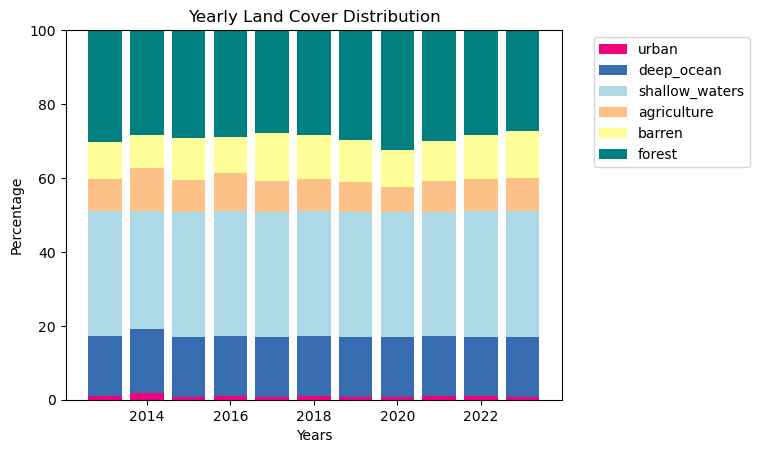

In [58]:
# Extract the years and land covers from yearly_results
years = list(yearly_results.keys())
land_covers = list(yearly_results[years[0]].keys())

# Prepare the data for the stacked bar chart
data = []
for land_cover in land_covers:
    values = [yearly_results[year][land_cover] for year in years]
    data.append(values)

colors = PALETTE[:len(land_covers)]

# Create the stacked bar chart
fig, ax = plt.subplots()
ax.bar(years, data[0], label=land_covers[0], color=colors[0])
cumulative_data = data[0]
for i in range(1, len(land_covers)):
    ax.bar(years, data[i], bottom=cumulative_data, label=land_covers[i], color=colors[i])
    cumulative_data = [x + y for x, y in zip(cumulative_data, data[i])]

# Set the labels and title
ax.set_xlabel('Years')
ax.set_ylabel('Percentage')
ax.set_title('Yearly Land Cover Distribution')

# Set y axis to be from 0 to 100
ax.set_ylim(0, 100)

# Add a legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


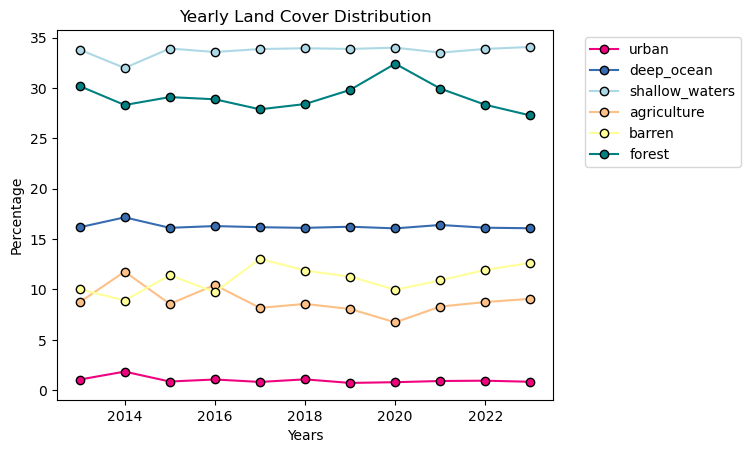

In [70]:
# Extract the years and land covers from yearly_results
years = list(yearly_results.keys())
land_covers = list(yearly_results[years[0]].keys())

# Prepare the data for the line graph
data = []
for land_cover in land_covers:
    values = [yearly_results[year][land_cover] for year in years]
    data.append(values)

colors = PALETTE[:len(land_covers)]

# Create the line graph
fig, ax = plt.subplots()
for i in range(len(land_covers)):
    ax.plot(years, data[i], label=land_covers[i], color=colors[i], marker='o', markeredgecolor='black')

# Set the labels and title
ax.set_xlabel('Years')
ax.set_ylabel('Percentage')
ax.set_title('Yearly Land Cover Distribution')

# Add a legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()
